# Commitment Transactions vs Flow Type

Pipeline to extract all commitment transactions in IATI data with associated Flow types\.

# Setup

Connecting to https://iati\-tables\.codeforiati\.org/ to pull data\.

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter

sns.set_context('notebook')

#start noteql session
import noteql
# Restart postgres to make sure any existing connections get dropped
!sudo service postgresql restart
session = noteql.Session(datasette_url='https://datasette.tables.iatistandard.org/iati.json', connect_args={'connect_timeout': 1000})

postgresql: unrecognized service
Using db connection https://datasette.tables.iatistandard.org/iati.json 


Read in CRS flow type codelist

In [2]:
#read codelist
flowtype = pd.read_csv("FlowType.csv")
flowtype['code'] = flowtype['code'].astype(str)
flowtype

,code,name,description,category,url,status
0,10,ODA,Official Development Assistance,NaN,NaN,active
1,20,OOF,Other Official Flows,NaN,NaN,withdrawn
2,21,Non-export credit OOF,"Other Official Flows, excl. export credits",NaN,NaN,active
3,22,Officially supported export credits,Officially supported export credits. Covers bo...,NaN,NaN,active
4,30,Private Development Finance,Financing by civil society organisations (NGOs...,NaN,NaN,active
5,35,Private Market,Private long-term (i.e. over one-year maturity...,NaN,NaN,withdrawn
6,36,Private Foreign Direct Investment,Private Foreign Direct Investment,NaN,NaN,active
7,37,Other Private flows at market terms,Private long-term (i.e. over one-year maturity...,NaN,NaN,active
8,40,Non flow,"e.g. GNI, ODA%GNI, Population etc",NaN,NaN,active
9,50,Other flows,e.g. non-ODA component of peacebuilding operat...,NaN,NaN,active


# Download data

## All outgoing commitment transactions

Where: 

-  date is not null

- year is 2010 to 2024 

- iati\-identifier is not null

In [4]:
%%nql SHOW commitments=DF

SELECT
    iatiidentifier, 
    reportingorg_ref,
    transactiontype_code, 
    transactiontype_codename, 
    SUBSTRING(transactiondate_isodate, 1, 4) as 'year',
    SUM(value_usd) as 'sum_value_usd',
    flowtype_code, 
    flowtype_codename
FROM trans
WHERE 
   transactiontype_code=2
   AND (transactiondate_isodate is not null and transactiondate_isodate != "")
   AND (CAST(SUBSTRING(transactiondate_isodate, 1, 4) as numeric) > 2009 AND
   CAST(SUBSTRING(transactiondate_isodate, 1, 4) as numeric) < 2025) AND
    ("iatiidentifier" is not null and "iatiidentifier" != "")
GROUP BY iatiidentifier, reportingorg_ref, transactiontype_code, transactiontype_codename, 
        SUBSTRING(transactiondate_isodate, 1, 4),flowtype_code, flowtype_codename

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename
0,\n\t\t\tUS-501c3-522318905-SG-1120091041832\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,2.920019e+05,,
1,\n\t\t\tUS-501c3-522318905-SG-1120091041893\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,1.397649e+05,,
2,\n\t\t\tUS-501c3-522318905-SG-1120091041899\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,2.753709e+05,,
3,\n\t\t\tUS-501c3-522318905-SG-1120091042919\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,4.370966e+05,,
4,\n\t\t\tUS-501c3-522318905-SG-1120091042923\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,5.457151e+05,,
...,...,...,...,...,...,...,...,...
654169,ZA-NPO-053-456-R2GCEGAAManagement,ZA-NPO-053-456,2,Outgoing Commitment,2022,4.652299e+04,,
654170,ZA-NPO-060766-PU1-KE,ZA-NPO-060766,2,Outgoing Commitment,2022,2.640500e+04,,
654171,ZA-NPO-060766-PU1-UG,ZA-NPO-060766,2,Outgoing Commitment,2022,2.640500e+04,,
654172,ZA-PBO-930040668-2302,ZA-PBO-930040668,2,Outgoing Commitment,2016,1.106136e+06,,


Check dates are correct \- should be 2010 onwards

In [4]:
set(commitments['year'])

{2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024}

## All activities with Default flow type

Where the flow type is not declared at transaction level, use the default flow type if included\.

In [5]:
%%nql SHOW activities_defaultflow=DF

SELECT DISTINCT
    iatiidentifier, 
    defaultflowtype_code,
    defaultflowtype_codename
FROM activity
WHERE ("defaultflowtype_code" is not null and "defaultflowtype_code" != "") AND
        ("iatiidentifier" is not null and "iatiidentifier" != "")

,iatiidentifier,defaultflowtype_code,defaultflowtype_codename
0,BF-MATD-1131-#44218,10,ODA
1,DK-CVR-31378028-SPA-2020,10,ODA
2,BE-BCE_KBO-0421210424-prg2022,30,Private Development Finance
3,BE-BCE_KBO-0421210424-prg2022-5-CD,30,Private Development Finance
4,BE-BCE_KBO-0421210424-prg2022-6-BI,30,Private Development Finance
...,...,...,...
624649,NL-KVK-41009723-SDN2401,30,Private Development Finance
624650,NL-KVK-41009723-01-ARC DR CONGO-ZOA,30,Private Development Finance
624651,NL-KVK-41009723-SDN2405,30,Private Development Finance
624652,NL-KVK-41009723-NSU989,30,Private Development Finance


Check for and remove duplicate activities \- due to reporting activities across multiple files\.

In [6]:
len(set(activities_defaultflow['iatiidentifier']))

624651

In [7]:
dups = [k for k,v in Counter(activities_defaultflow['iatiidentifier']).items() if v>1]
dups

['NL-KVK-41197577-2020DLJR-I',
 'NL-KVK-41197577-2020DLJR-L',
 'US-GOV-11-FA8655331 SLMAQM19CA2256']

In [8]:
activities_defaultflow = activities_defaultflow[~activities_defaultflow['iatiidentifier'].isin(dups)]
activities_defaultflow['defaultflowtype_code'] = activities_defaultflow.loc[:,('defaultflowtype_code')].astype(str)
activities_defaultflow

/tmp/ipykernel_752/403680399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activities_defaultflow['defaultflowtype_code'] = activities_defaultflow.loc[:,('defaultflowtype_code')].astype(str)


,iatiidentifier,defaultflowtype_code,defaultflowtype_codename
0,BF-MATD-1131-#44218,10,ODA
1,DK-CVR-31378028-SPA-2020,10,ODA
2,BE-BCE_KBO-0421210424-prg2022,30,Private Development Finance
3,BE-BCE_KBO-0421210424-prg2022-5-CD,30,Private Development Finance
4,BE-BCE_KBO-0421210424-prg2022-6-BI,30,Private Development Finance
...,...,...,...
624649,NL-KVK-41009723-SDN2401,30,Private Development Finance
624650,NL-KVK-41009723-01-ARC DR CONGO-ZOA,30,Private Development Finance
624651,NL-KVK-41009723-SDN2405,30,Private Development Finance
624652,NL-KVK-41009723-NSU989,30,Private Development Finance


# Combine dataframes

Join on default flow type values from activities, and use these values where they are not declared at transaction level\.

Remove known duplicate activities\.

In [9]:
combined = commitments.merge(activities_defaultflow, on="iatiidentifier",how='left')

combined.loc[combined['flowtype_code'] =='', 'comb_flowtype_code'] = combined['defaultflowtype_code']
combined.loc[combined['flowtype_code'] !='', 'comb_flowtype_code'] = combined['flowtype_code']

combined.loc[combined['flowtype_codename'] =='', 'comb_flowtype_codename'] = combined['defaultflowtype_codename']
combined.loc[combined['flowtype_codename'] !='', 'comb_flowtype_codename'] = combined['flowtype_codename']

combined = combined[~combined['iatiidentifier'].isin(dups)]

combined

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename,defaultflowtype_code,defaultflowtype_codename,comb_flowtype_code,comb_flowtype_codename
0,\n\t\t\tUS-501c3-522318905-SG-1120091041832\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,2.920019e+05,,,NaN,NaN,NaN,NaN
1,\n\t\t\tUS-501c3-522318905-SG-1120091041893\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,1.397649e+05,,,NaN,NaN,NaN,NaN
2,\n\t\t\tUS-501c3-522318905-SG-1120091041899\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,2.753709e+05,,,NaN,NaN,NaN,NaN
3,\n\t\t\tUS-501c3-522318905-SG-1120091042919\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,4.370966e+05,,,NaN,NaN,NaN,NaN
4,\n\t\t\tUS-501c3-522318905-SG-1120091042923\n\t\t,US-501c3-522318905,2,Outgoing Commitment,2011,5.457151e+05,,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
652818,ZA-NPO-053-456-R2GCEGAAManagement,ZA-NPO-053-456,2,Outgoing Commitment,2022,4.652299e+04,,,NaN,NaN,NaN,NaN
652819,ZA-NPO-060766-PU1-KE,ZA-NPO-060766,2,Outgoing Commitment,2022,2.640500e+04,,,30,Private Development Finance,30,Private Development Finance
652820,ZA-NPO-060766-PU1-UG,ZA-NPO-060766,2,Outgoing Commitment,2022,2.640500e+04,,,30,Private Development Finance,30,Private Development Finance
652821,ZA-PBO-930040668-2302,ZA-PBO-930040668,2,Outgoing Commitment,2016,1.106136e+06,,,NaN,NaN,NaN,NaN


## Filter data

Filter out na values for combined flowtype \- where they are not declared in a transaction or at activity level\.

Filter out values not in the flow type code list\.

In [10]:
combined_filt = combined[combined['comb_flowtype_code'].isin(flowtype['code'])]
combined_filt

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename,defaultflowtype_code,defaultflowtype_codename,comb_flowtype_code,comb_flowtype_codename
3154,--1210000_2024_001,KR-GOV-010,2,Outgoing Commitment,2024,2.141022e+05,10,ODA,10,ODA,10,ODA
3155,--1230000_2022_001,KR-GOV-010,2,Outgoing Commitment,2024,3.882387e+05,10,ODA,10,ODA,10,ODA
3156,21-PK-WWF-GPAF-IMP-019,21-PK-WWF,2,Outgoing Commitment,2012,1.838722e+06,30,Private Development Finance,30,Private Development Finance,30,Private Development Finance
3157,21-PK-WWF-GPAF-IMP-033,21-PK-WWF,2,Outgoing Commitment,2012,3.527814e+05,30,Private Development Finance,30,Private Development Finance,30,Private Development Finance
3158,41AAA-00079961,41AAA,2,Outgoing Commitment,2011,4.192921e+06,,,20,OOF,20,OOF
...,...,...,...,...,...,...,...,...,...,...,...,...
652815,ZA-NPO-048-364-SSN_VCA,ZA-NPO-048-364,2,Outgoing Commitment,2023,9.058499e+05,,,30,Private Development Finance,30,Private Development Finance
652816,ZA-NPO-048-364-SSN_VCA,ZA-NPO-048-364,2,Outgoing Commitment,2024,1.390118e+05,,,30,Private Development Finance,30,Private Development Finance
652819,ZA-NPO-060766-PU1-KE,ZA-NPO-060766,2,Outgoing Commitment,2022,2.640500e+04,,,30,Private Development Finance,30,Private Development Finance
652820,ZA-NPO-060766-PU1-UG,ZA-NPO-060766,2,Outgoing Commitment,2022,2.640500e+04,,,30,Private Development Finance,30,Private Development Finance


Save filtered data to spreadsheet

In [ ]:
!rm -rf commitvsflow_data.xlsx

combined_filt.to_excel("commitvsflow_data.xlsx",sheet_name="commitvsflow", index=False)

Pull out data to plot and sum over unique flow type and years\. 

In [11]:
combined_plot = combined_filt[['comb_flowtype_code','comb_flowtype_codename','year','sum_value_usd']]
combined_plot = combined_plot.groupby(['comb_flowtype_code','comb_flowtype_codename','year']).sum().reset_index()
combined_plot['usd_mil'] = combined_plot['sum_value_usd']/1000000
combined_plot

,comb_flowtype_code,comb_flowtype_codename,year,sum_value_usd,usd_mil
0,10,ODA,2010,4.130715e+10,41307.149472
1,10,ODA,2011,4.463658e+10,44636.581968
2,10,ODA,2012,7.322881e+10,73228.809740
3,10,ODA,2013,8.815822e+10,88158.224236
4,10,ODA,2014,1.142761e+11,114276.144303
...,...,...,...,...,...
115,50,Other flows,2020,4.145157e+10,41451.571242
116,50,Other flows,2021,3.361247e+10,33612.471503
117,50,Other flows,2022,4.410074e+10,44100.741678
118,50,Other flows,2023,3.362440e+10,33624.402599


# Visualise

In [12]:
#Palette 
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade 
COLOR_SCALE = [
    "#7F3C8D", 
    "#11A579", 
    "#3969AC", 
    "#F2B701", 
    "#E73F74", 
    "#80BA5A", 
    "#E68310", 
    GREY50     
]

# Vertical lines every 5 years
VLINES = np.arange(2010, 2030, 5)

10 #7F3C8D
20 #11A579
21 #3969AC
30 #F2B701
35 #E73F74
36 #80BA5A
37 #E68310
50 #7f7f7f


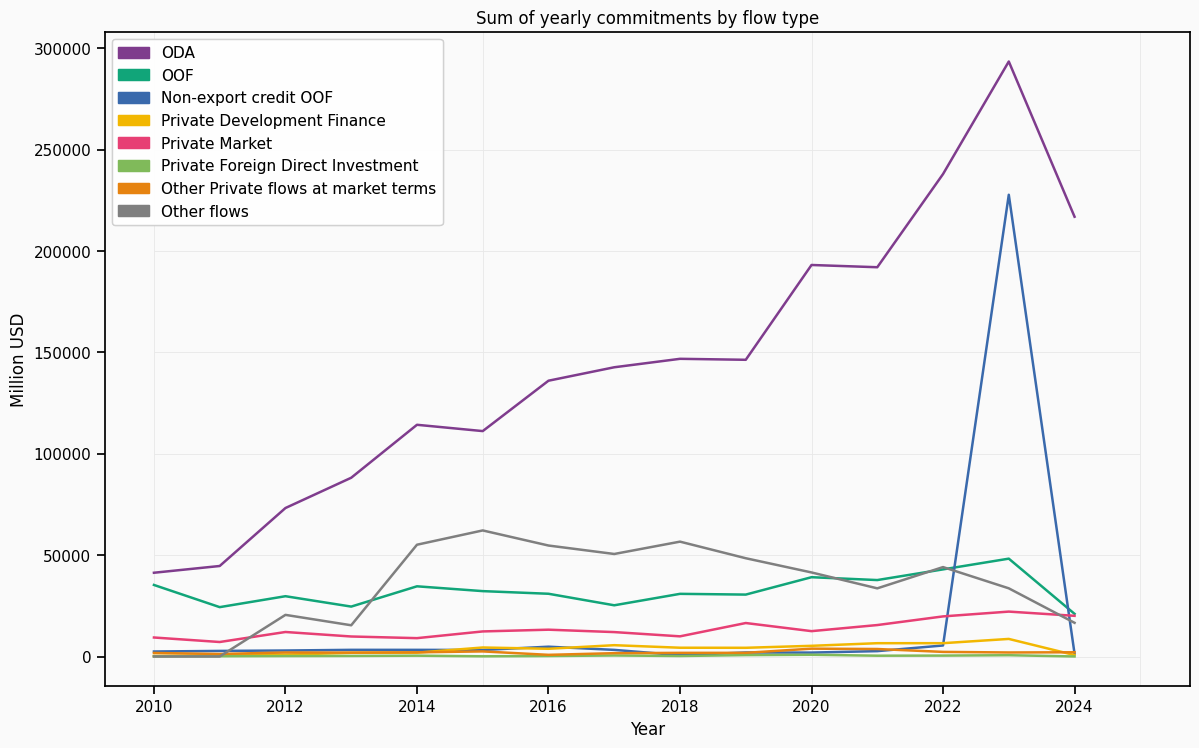

In [13]:
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 300000,50000), xmin=2010, xmax=2025, color=GREY91, lw=0.6)

ax.set_xlabel('Year')
ax.set_ylabel('Million USD')
ax.set_title('Sum of yearly commitments by flow type')

#legend
patch1 = mpatches.Patch(color="#7F3C8D", label='ODA')
patch2 = mpatches.Patch(color="#11A579",  label='OOF')
patch3 = mpatches.Patch(color="#3969AC",  label='Non-export credit OOF')
patch4 = mpatches.Patch(color="#F2B701", label='Private Development Finance')
patch5 = mpatches.Patch(color="#E73F74", label='Private Market')
patch6 = mpatches.Patch(color="#80BA5A", label='Private Foreign Direct Investment')
patch7 = mpatches.Patch(color="#E68310",  label='Other Private flows at market terms')
patch8 = mpatches.Patch(color=GREY50, label='Other flows')

all_handles = (patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8)
leg = ax.legend(handles=all_handles)

ax.add_artist(leg)

# Add lines ------------------------------------------------------
for idx, group in enumerate(combined_plot["comb_flowtype_code"].unique()):
    data = combined_plot[combined_plot["comb_flowtype_code"] == group]
    color = COLOR_SCALE[idx]
    print(group, color)
    ax.plot("year", "usd_mil", color=color, lw=1.8, data=data)


Save data used in plot to spreadsheet

In [14]:
!rm -rf commitvsflow_plot.xlsx 

combined_plot.to_excel("commitvsflow_plot.xlsx",sheet_name="commitvsflow", index=False)